<a href="https://colab.research.google.com/github/alexmplastow/IE534-CS547-Emmerson/blob/main/deepNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
!wget -c https://data.cdc.gov/api/views/xkb8-kh2a/rows.csv?accessType=DOWNLOAD&bom=true&format=true -O Drug_Overdose_Deaths.csv #name did not changed...

/bin/bash: -O: command not found
--2022-12-09 23:56:43--  https://data.cdc.gov/api/views/xkb8-kh2a/rows.csv?accessType=DOWNLOAD
Resolving data.cdc.gov (data.cdc.gov)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cdc.gov (data.cdc.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [    <=>             ]   9.20M  9.81MB/s    in 0.9s    

2022-12-09 23:56:45 (9.81 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [9651249]



# Importing necessary Modules

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function Declarations

In [ ]:
#Input, dataframe which you wish to encode for one column
#Output, the same dataframe with an encoding for a single column
def categoricalEncoding(category, df):
  Encoder = dict([(j, i) for i,j in enumerate(list(set(df[category])))])
  Encoding = pd.Series([Encoder[state] for state in df[category]])
  df[category] = Encoding
  return df

#Input: column for normalization and the dataframe
#Output: The same dataframe, just with the specified column normalized
columnNormalization = lambda column, df : \
                      (df[column] - df[column].min())  \
                      / (df[column].max() - df[column].min())



def trainingLoop(inputTensor, outputTensor, modelNo, optim_alg='AdamW'):
	#Defining an instance of the model
	our_model = model()

	#The losses are calculated for each batch if the size_average boolean is set
		#to false
	# Test different Loss Functions
	criterion = torch.nn.MSELoss(size_average = False)
  # criterion = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

	#I had too lower the learning rate to avoid exploring ridiculous parameter spaces
	
	#It seems lowering the learning rate increases the number of epochs before convergence
		#but not much else

	#lr = 0.00001
	#Raising the learning rate seems to significantly decrease the number of epochs
	#before convergence

	#lr = 0.0001
	#If I increase the learning rate by two orders of magnitude, entropy grows exponentially
	if optim_alg == 'Adam':
		optimizer = torch.optim.Adam(our_model.parameters(), lr = 0.001)
	elif optim_alg == "AdamW":
		optimizer = torch.optim.AdamW(our_model.parameters(), lr = 0.001)
	else:
		optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.000001)

	losses = []
	
	for epoch in range(500):

		#Calculating the prediction space based on model parameters
		pred_y = our_model(inputTensor.float())

		# Computing loss
		loss = criterion(pred_y, outputTensor.float())

		#The "zero_grad()" method  clears data on the gradient
			#We want to recalculate the gradient at every go
		optimizer.zero_grad()

		#Weights are updated here, a step is taken on the plane of possible
			#parameter combinations

		loss.backward()
		optimizer.step()

		#I store the losses to graph later
		losses.append(loss.item())

	plt.plot(list(range(0,500)), losses)
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Loss vs Epoch')
	plt.show()
	torch.save(our_model.state_dict(), '/home/modelNo{}'.format(str(modelNo)))
	return round(min(losses), 3)
 

def miniBatchTrainingLoop(inputTensor, outputTensor, modelNo, optim_alg='AdamW'):
	#Defining an instance of the model
	our_model = model()

	#The losses are calculated for each batch if the size_average boolean is set
		#to false
	# Test different Loss Functions
	criterion = torch.nn.MSELoss(size_average = False)
	# criterion = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

	#I had too lower the learning rate to avoid exploring ridiculous parameter spaces

	#It seems lowering the learning rate increases the number of epochs before convergence
		#but not much else

	#lr = 0.00001
	#Raising the learning rate seems to significantly decrease the number of epochs
	#before convergence

	#lr = 0.0001
	#If I increase the learning rate by two orders of magnitude, entropy grows exponentially
	if optim_alg == 'Adam':
		optimizer = torch.optim.Adam(our_model.parameters(), lr = 0.001)
	elif optim_alg == "AdamW":
		optimizer = torch.optim.AdamW(our_model.parameters(), lr = 0.001)
	else:
		optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.000001)

	losses = []


	#Defining a minibatch scheme
	batchSize = 2000

	for epoch in range(500):

		permutation = torch.randperm(inputTensor.size()[0])
	
		for iteration in range(0, inputTensor.size()[0], batchSize):

			indices = permutation[iteration:iteration+batchSize]

			batchX = inputTensor.float()[indices]
			batchY = outputTensor.float()[indices]

			#Calculating the prediction space based on model parameters
			pred_y = our_model(batchX)

			# Computing loss
			loss = criterion(pred_y, batchY)

			#The "zero_grad()" method  clears data on the gradient
				#We want to recalculate the gradient at every go
			optimizer.zero_grad()

			#Weights are updated here, a step is taken on the plane of possible
				#parameter combinations

			loss.backward()
			optimizer.step()

		#I store the losses to graph later
		losses.append(loss.item())

	plt.plot(list(range(0,500)), losses)
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Loss vs Epoch')
	plt.show()
	torch.save(our_model.state_dict(), '/home/modelNo{}'.format(str(modelNo)))
	return round(min(losses), 3)

## Data processing

In [ ]:
df = pd.read_csv('rows.csv?accessType=DOWNLOAD').dropna().reset_index()

#I see in the "main.py" script, there was an action to drop useless features
#I haven't combed through them all, but I'm going to trust my teammates
#judgement


df = df.drop(labels=["State Name", "Period", "Percent Complete", "Footnote",
                     "Footnote Symbol", "Predicted Value"], axis=1) #"Percent Pending Investigation",

#I am operating under the not entirely unreasonable assumption that
  #'Data Value' produces the "predicted values" by using the other parameters
  #to train a prediction for the "Predicted Value" column

outputDf = pd.DataFrame(df['Data Value'], columns=["Data Value"])
inputDf = df.drop(labels=['Data Value'], axis = 1)

#Encoding the data
  #I opted not to use one-hot encoding, I figured fifty categorical variables
  #Wouldn't improve the quality of the learning algorithm
  #But I certainly wouldn't mind if somebody proved me wrong

#It looks to me like the data is encoded properly
print(set(inputDf.Indicator))

for category in ["State", "Month", "Indicator"]:
  inputDf = categoricalEncoding(category, inputDf)

for category in ["State", "Month", "Year", "Indicator"]:
  inputDf[category] = columnNormalization(category, inputDf)

inputDf = inputDf.drop(columns='index')

#I had to add this abomination to get the code running
#outputDf["Data Value"] = \
#    pd.Series([float(string.replace(',','')) for string in outputDf["Data Value"]])


outputDf["Data Value"] = columnNormalization("Data Value", outputDf)

inputArray = np.array(inputDf)
outputArray = np.array(outputDf).reshape(len(outputDf), 1)

inputTensor = torch.from_numpy(inputArray).unsqueeze(dim=0).type(torch.double)
outputTensor = torch.from_numpy(outputArray).unsqueeze(dim=0).type(torch.double)

print(inputTensor)

{'Heroin (T40.1)', 'Number of Drug Overdose Deaths', 'Opioids (T40.0-T40.4,T40.6)', 'Cocaine (T40.5)', 'Natural & semi-synthetic opioids (T40.2)', 'Psychostimulants with abuse potential (T43.6)', 'Methadone (T40.3)', 'Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)', 'Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)', 'Synthetic opioids, excl. methadone (T40.4)'}
tensor([[[0.4423, 0.0000, 0.9091, 0.1111, 0.0000],
         [0.4423, 0.0000, 0.3636, 0.1111, 0.0000],
         [0.4423, 0.0000, 0.4545, 0.1111, 0.0000],
         ...,
         [0.5000, 1.0000, 0.5455, 0.1111, 0.3704],
         [0.5000, 1.0000, 0.5455, 0.4444, 0.3704],
         [0.5000, 1.0000, 0.5455, 1.0000, 0.3704]]], dtype=torch.float64)


## Model

##  Fully Connected Model

In [ ]:
class model(torch.nn.Module):

#It seems as if altering the # of layers has a minimal effect on entropy
  #Further, the marginal benefits of layers wanes after three layers
#For six layers, the model converges with an average entropy of 10.430 for each fold
#For five: 10.430
#For four: 10.407
#For three: 10.753
#For two: 11.038
#For one: 11.890

    def __init__(self):
        super(model, self).__init__()
        # Five in and one out
        self.layer1 = torch.nn.Linear(5, 5)  
        self.layer2 = torch.nn.Linear(5, 5)
        self.layer3 = torch.nn.Linear(5, 5)
        self.layer4 = torch.nn.Linear(5, 5)
        #self.layer5 = torch.nn.Linear(4, 4)
        #self.layer6 = torch.nn.Linear(4, 4)
        self.output = torch.nn.Linear(5, 1)

    def forward(self, x):
        z = torch.relu(self.layer1(x))
        z = torch.relu(self.layer2(z))
        z = torch.relu(self.layer3(z))
        z = torch.sigmoid(self.layer4(z))
        #z = torch.relu(self.layer5(z))
        #z = torch.relu(self.layer6(z))
        z = self.output(z)
        return z


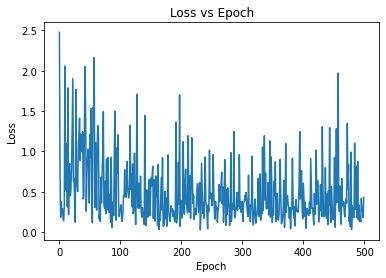

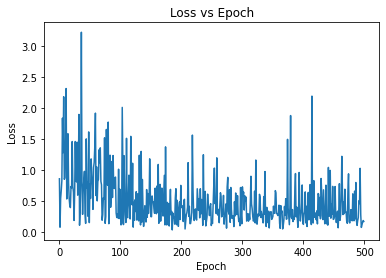

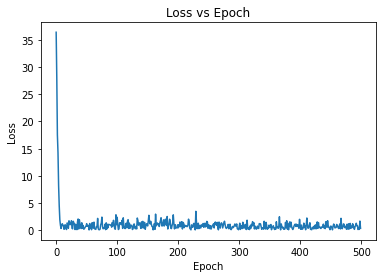

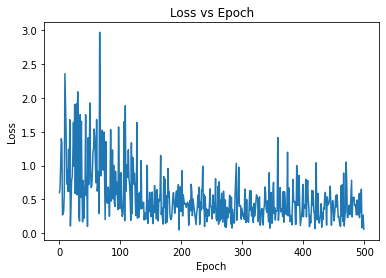

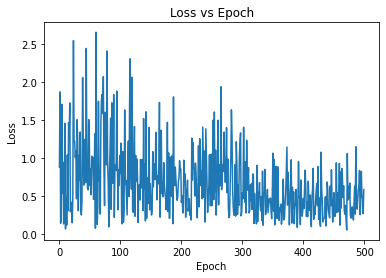

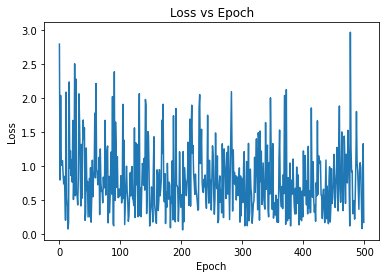

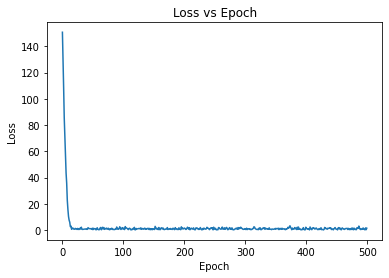

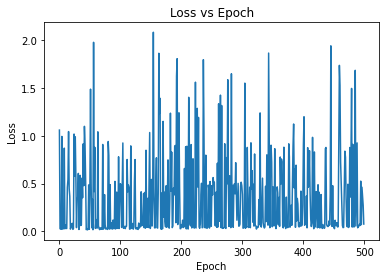

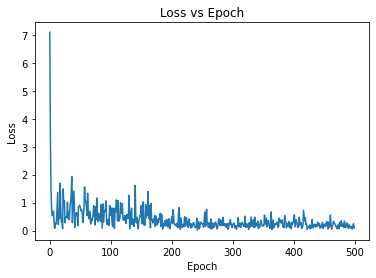

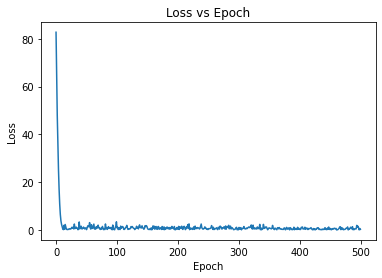

The model performance is evaluated at an RMSD per data point of 3.765126541877048e-05
0.005522190678499459
Final loss:  0.04970000000000001


In [ ]:
#I borrowed this function from another project, it does not generalize
#to pandas dataframes, so
#Input: data frame (we use an nd.array object here), labels (also nd.array), and the division of folds
#Output: partitioned arrays paired in tuples
def partition(X, Y, partitionsInPercent):
  inputDimensions = X.shape

  if sum(partitionsInPercent) != 100:
    raise Exception('You are not entering fold sizes which add'
                    'to 100%, enter the k-fold percent, '
                    'the validation percent, and the testing percent')
  fractionCovered = 0
  partitions = []

  for partitionSizeInPercent in partitionsInPercent:
    alpha = int((fractionCovered) * inputDimensions[0])
    omega = int((fractionCovered + partitionSizeInPercent /
                 100) * inputDimensions[0])
    dataRange = range(alpha, omega)
    fractionCovered += partitionSizeInPercent / 100
    partitions.append(tuple((X[dataRange, :], Y[dataRange,])))

  return partitions

partitions = partition(
    inputTensor.reshape([inputTensor.shape[-2], inputTensor.shape[-1]]), 
    outputTensor.reshape([outputTensor.shape[-2], outputTensor.shape[-1]]), 
    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

trainingPartitions = partitions[0:11]

class modelPerformance:
  def __init__(self, model, errorInSample, errorOutOfSample):
    self.model = model
    self.errorInSample = errorInSample
    self.errorOutOfSample = errorOutOfSample

  def overfitTest(self):
    return abs(self.errorInSample - self.errorOutOfSample)

#TODO: you have a larger partition than you ought to, it looks like the final
  #TODO: validation partition is inadvertently being included in the loop below

modelPerformances = []
FCN_final_loss = []
for i_no, kFold in enumerate(trainingPartitions):
  
  trainingIndices = list(range(0, len(trainingPartitions)))
  trainingIndices.remove(i_no)

  inputPartitions = torch.cat([partitions[index][0] for index in trainingIndices])
  outputPartitions = torch.cat([partitions[index][-1] for index in trainingIndices])

  #inputPartitions = addDimension(inputPartitions)
  #outputPartitions = addDimension(outputPartitions)

  inSampleLoss = miniBatchTrainingLoop(inputPartitions, outputPartitions, i_no)
  FCN_final_loss.append(inSampleLoss)

  ourModel = model()
  
  #ourModel = rnnModel(inputSize=4, outputSize=1, hiddenDim=2, layerNum=2)
  
  ourModel.load_state_dict(torch.load('/home/modelNo{}'.format(str(i_no))))

  #The losses are calculated for each batch if the size_average boolean is set
  #to false
  criterion = torch.nn.MSELoss(size_average = False)

	# Computing loss
  outOfSampleLoss = criterion(ourModel(kFold[0].float()), kFold[-1].float()).item()
  #The entropy is not adjusted for sample size, so I added this correction
  correction = kFold[0].shape[0]/inputPartitions.shape[0]

  modelPerformances.append(modelPerformance(ourModel, correction*inSampleLoss, 
                                            outOfSampleLoss))
  
#Bit lengthy, so what I am doing here is going over the collection of models
  #from the k-fold validation, then choosing the one which has the smallest
  #difference between the in-sample and out-of-sample tests
bestModel = sorted([tuple([modelPerformance, modelPerformance.overfitTest()]) 
                    for modelPerformance in modelPerformances], 
                   key = lambda x: x[-1])[0][0].model


test = criterion(bestModel(partitions[-1][0].float()), 
                 partitions[-1][-1].float()).item()

#The output seems too good to be true
print('The model performance is evaluated at an RMSD per data point of ' + 
     str(test/partitions[-1][0].shape[0]))

inSamplePerformance = sorted([modelPerformance.errorInSample 
                       for modelPerformance in modelPerformances])
print(np.mean(inSamplePerformance))
print("Final loss: ", np.mean(FCN_final_loss))

## RNN Model

We attempted to implament a recurrent neural network as part of the regression problem, but with little success. The code runs, but is alarmingly slow. We are not certain why. The problem could be in the tensor dimensions (e.g. if we are inadvertently switching rows for columns or vice versa, that could make a single epoch longer than it ought to be)

We have seperated this from the main body of code to avoid corrupting the working neural network, much of the content is redundant

In [ ]:
# I borrowed some ideas from here:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

INPUT_SIZE=5

class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = torch.nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=5, 
            num_layers=1,  
            batch_first=True,  
        )
        self.out = torch.nn.Linear(5, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []  # save all predictions
        for time_step in range(r_out.size(1)):  # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

def trainingLoop(inputTensor, outputTensor, modelNo, optim_alg='AdamW'):
    
    # Defining an instance of the model
    #our_model = rnnModel(inputSize=5, outputSize=1, hiddenDim=2, layerNum=2)

    # our_model = model()
    our_model = RNN()

    # The losses are calculated for each batch if the size_average boolean is set
    # to false
    # Test different Loss Functions
    criterion = torch.nn.MSELoss(size_average=False)
    # criterion = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

    # I had too lower the learning rate to avoid exploring ridiculous parameter spaces

    # It seems lowering the learning rate increases the number of epochs before convergence
    # but not much else

    # lr = 0.00001
    # Raising the learning rate seems to significantly decrease the number of epochs
    # before convergence

    # lr = 0.0001
    # If I increase the learning rate by two orders of magnitude, entropy grows exponentially
    if optim_alg == 'Adam':
        optimizer = torch.optim.Adam(our_model.parameters(), lr=0.001)
    elif optim_alg == "AdamW":
        optimizer = torch.optim.AdamW(our_model.parameters(), lr=0.1)
    else:
        optimizer = torch.optim.SGD(our_model.parameters(), lr=0.000001)

    losses = []

    h_state = None

    print('////////////////////////////////////')
    print(inputTensor.shape)
    
    inputTensor = inputTensor.reshape(1 ,inputTensor.shape[0], inputTensor.shape[-1])
    outputTensor = outputTensor.reshape(1, outputTensor.shape[0], outputTensor.shape[-1])

    print(inputTensor.shape)
    print(outputTensor.shape)
    print('////////////////////////////////////')

    epochs = 3

    for epoch in range(epochs):

        # Calculating the prediction space based on model parameters
        pred_y, h_state = our_model(inputTensor.float(), h_state)

        h_state = h_state.data

        # Computing loss
        loss = criterion(pred_y, outputTensor.float())

        # The "zero_grad()" method  clears data on the gradient
        # We want to recalculate the gradient at every go
        optimizer.zero_grad()

        # Weights are updated here, a step is taken on the plane of possible
        # parameter combinations

        loss.backward()
        optimizer.step()

        # I store the losses to graph later
        losses.append(loss.item())

    plt.plot(list(range(0, epochs)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show()
    torch.save(our_model.state_dict(), '/home/modelNo{}'.format(str(modelNo)))
    return round(min(losses), 3)

////////////////////////////////////
torch.Size([30284, 5])
torch.Size([1, 30284, 5])
torch.Size([1, 30284, 1])
////////////////////////////////////


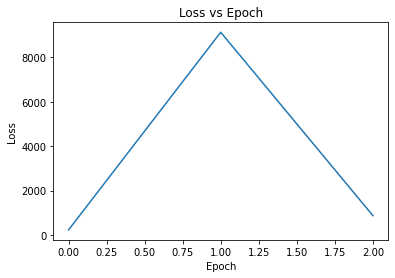

////////////////////////////////////
torch.Size([30283, 5])
torch.Size([1, 30283, 5])
torch.Size([1, 30283, 1])
////////////////////////////////////


KeyboardInterrupt: ignored

In [ ]:
#I borrowed this function from another project, it does not generalize
#to pandas dataframes, so
#Input: data frame (we use an nd.array object here), labels (also nd.array), and the division of folds
#Output: partitioned arrays paired in tuples
def partition(X, Y, partitionsInPercent):
  inputDimensions = X.shape

  if sum(partitionsInPercent) != 100:
    raise Exception('You are not entering fold sizes which add'
                    'to 100%, enter the k-fold percent, '
                    'the validation percent, and the testing percent')
  fractionCovered = 0
  partitions = []

  for partitionSizeInPercent in partitionsInPercent:
    alpha = int((fractionCovered) * inputDimensions[0])
    omega = int((fractionCovered + partitionSizeInPercent /
                 100) * inputDimensions[0])
    dataRange = range(alpha, omega)
    fractionCovered += partitionSizeInPercent / 100
    partitions.append(tuple((X[dataRange, :], Y[dataRange,])))

  return partitions

partitions = partition(
    inputTensor.reshape([inputTensor.shape[-2], inputTensor.shape[-1]]), 
    outputTensor.reshape([outputTensor.shape[-2], outputTensor.shape[-1]]), 
    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

trainingPartitions = partitions[0:11]

class modelPerformance:
  def __init__(self, model, errorInSample, errorOutOfSample):
    self.model = model
    self.errorInSample = errorInSample
    self.errorOutOfSample = errorOutOfSample

  def overfitTest(self):
    return abs(self.errorInSample - self.errorOutOfSample)

#TODO: you have a larger partition than you ought to, it looks like the final
  #TODO: validation partition is inadvertently being included in the loop below

modelPerformances = []
CNN_final_loss = []
for i_no, kFold in enumerate(trainingPartitions):
  
  trainingIndices = list(range(0, len(trainingPartitions)))
  trainingIndices.remove(i_no)

  inputPartitions = torch.cat([partitions[index][0] for index in trainingIndices])
  outputPartitions = torch.cat([partitions[index][-1] for index in trainingIndices])

  #inputPartitions = addDimension(inputPartitions)
  #outputPartitions = addDimension(outputPartitions)

  inSampleLoss = trainingLoop(inputPartitions, outputPartitions, i_no)
  CNN_final_loss.append(inSampleLoss)

  #ourModel = model()
  
  #ourModel = RNN()
  
  #ourModel.load_state_dict(torch.load('/home/modelNo{}'.format(str(i_no))))

  #The losses are calculated for each batch if the size_average boolean is set
  #to false
  criterion = torch.nn.MSELoss(size_average = False)

	# Computing loss
  #outOfSampleLoss = criterion(ourModel(kFold[0].float()), kFold[-1].float()).item()
  #The entropy is not adjusted for sample size, so I added this correction
  correction = kFold[0].shape[0]/inputPartitions.shape[0]

  #modelPerformances.append(modelPerformance(ourModel, correction*inSampleLoss, 
  #                                          outOfSampleLoss))
  
#Bit lengthy, so what I am doing here is going over the collection of models
  #from the k-fold validation, then choosing the one which has the smallest
  #difference between the in-sample and out-of-sample tests
#bestModel = sorted([tuple([modelPerformance, modelPerformance.overfitTest()]) 
#                    for modelPerformance in modelPerformances], 
#                   key = lambda x: x[-1])[0][0].model


#test = criterion(bestModel(partitions[-1][0].float()), 
   #              partitions[-1][-1].float()).item()

#The output seems too good to be true
#print('The model performance is evaluated at an RMSD per data point of ' + 
   #   str(test/partitions[-1][0].shape[0]))

#inSamplePerformance = sorted([modelPerformance.errorInSample 
 #                      for modelPerformance in modelPerformances])
#print(np.mean(inSamplePerformance))
print("CNN final loss: ", np.mean(CNN_final_loss))